In [0]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Colab Notebooks/tomato/tomato_better_dataset'
!ls

/content/gdrive/My Drive/Colab Notebooks/tomato/tomato_better_dataset
test  train  validation


In [14]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(256, 256),
    batch_size=20)
validation_generator = validation_datagen.flow_from_directory(
    'validation',
    target_size=(256, 256),
    batch_size=20)

Found 800 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


In [0]:
# create the base pre-trained model
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(256,256,3))

In [16]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [17]:
len(conv_base.layers)

132

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 21,915,698
Trainable params: 21,861,170
Non-trainable params: 54,528
_________________________________________________________________


In [20]:
print('This is the number of trainable weights '
'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [21]:
conv_base.trainable = False
print('This is the number of trainable weights '
'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 321s 3s/step - loss: 1.6259 - accuracy: 0.4575 - val_loss: 1.3541 - val_accuracy: 0.5350
Epoch 2/30
100/100 [==============================] - 42s 420ms/step - loss: 1.0386 - accuracy: 0.6305 - val_loss: 1.3213 - val_accuracy: 0.5410
Epoch 3/30
100/100 [==============================] - 42s 420ms/step - loss: 0.8790 - accuracy: 0.6850 - val_loss: 1.3089 - val_accuracy: 0.5710
Epoch 4/30
100/100 [==============================] - 42s 422ms/step - loss: 0.7040 - accuracy: 0.7565 - val_loss: 1.0937 - val_accuracy: 0.6380
Epoch 5/30
100/100 [==============================] - 42s 420ms/step - loss: 0.6408 - accuracy: 0.7780 - val_loss: 1.1170 - val_accuracy: 0.6310
Epoch 6/30
100/100 [==============================] - 42s 417ms/step - loss: 0.5795 - accuracy: 0.7940 - val_loss: 1.1829 - val_accuracy: 0.6300
Epoch 7/30
100/100 [==============================] - 42s 416ms/step - loss: 0.5239 - accuracy: 0.8110 - val_loss: 1.0202 - val_accu

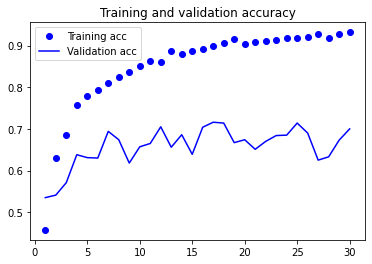

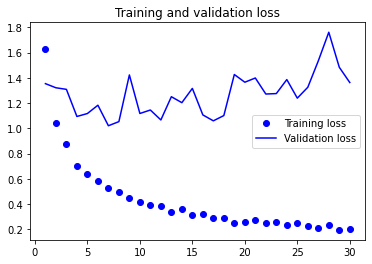

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
conv_base.trainable = True
for layer in conv_base.layers[:106]:
   layer.trainable = False
for layer in conv_base.layers[106:]:
   layer.trainable = True
print('This is the number of trainable weights '
'after unfreezing part of the conv base:', len(model.trainable_weights))

This is the number of trainable weights after unfreezing part of the conv base: 35


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [0]:
callbacks_list = [
  ModelCheckpoint(filepath='checkpointTomatoXception-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)
]

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks_list)

Epoch 1/100
100/100 [==============================] - 45s 447ms/step - loss: 0.2407 - accuracy: 0.9135 - val_loss: 1.0997 - val_accuracy: 0.7340 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 43s 435ms/step - loss: 0.1445 - accuracy: 0.9550 - val_loss: 1.3478 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 44s 436ms/step - loss: 0.1164 - accuracy: 0.9575 - val_loss: 0.9428 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 43s 433ms/step - loss: 0.0895 - accuracy: 0.9740 - val_loss: 1.0083 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 44s 436ms/step - loss: 0.0805 - accuracy: 0.9740 - val_loss: 0.9115 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 44s 435ms/step - loss: 0.0664 - accuracy: 0.9805 - val_loss: 1.0490 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 7/100
100/100 [=

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(256,256),
    batch_size=20)
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)